In [2]:
import scanpy as sc
import squidpy as sq
import pandas as pd
from tqdm.notebook import tqdm
import scipy as sp
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("E:/codex/CRC_clusters_neighborhoods_markers.csv", index_col=0)
features = [
       'CD44 - stroma:Cyc_2_ch_2', 'FOXP3 - regulatory T cells:Cyc_2_ch_3',
       'CD8 - cytotoxic T cells:Cyc_3_ch_2',
       'p53 - tumor suppressor:Cyc_3_ch_3',
       'GATA3 - Th2 helper T cells:Cyc_3_ch_4',
       'CD45 - hematopoietic cells:Cyc_4_ch_2', 'T-bet - Th1 cells:Cyc_4_ch_3',
       'beta-catenin - Wnt signaling:Cyc_4_ch_4', 'HLA-DR - MHC-II:Cyc_5_ch_2',
       'PD-L1 - checkpoint:Cyc_5_ch_3', 'Ki67 - proliferation:Cyc_5_ch_4',
       'CD45RA - naive T cells:Cyc_6_ch_2', 'CD4 - T helper cells:Cyc_6_ch_3',
       'CD21 - DCs:Cyc_6_ch_4', 'MUC-1 - epithelia:Cyc_7_ch_2',
       'CD30 - costimulator:Cyc_7_ch_3', 'CD2 - T cells:Cyc_7_ch_4',
       'Vimentin - cytoplasm:Cyc_8_ch_2', 'CD20 - B cells:Cyc_8_ch_3',
       'LAG-3 - checkpoint:Cyc_8_ch_4', 'Na-K-ATPase - membranes:Cyc_9_ch_2',
       'CD5 - T cells:Cyc_9_ch_3', 'IDO-1 - metabolism:Cyc_9_ch_4',
       'Cytokeratin - epithelia:Cyc_10_ch_2',
       'CD11b - macrophages:Cyc_10_ch_3', 'CD56 - NK cells:Cyc_10_ch_4',
       'aSMA - smooth muscle:Cyc_11_ch_2', 'BCL-2 - apoptosis:Cyc_11_ch_3',
       'CD25 - IL-2 Ra:Cyc_11_ch_4', 'CD11c - DCs:Cyc_12_ch_3',
       'PD-1 - checkpoint:Cyc_12_ch_4',
       'Granzyme B - cytotoxicity:Cyc_13_ch_2', 'EGFR - signaling:Cyc_13_ch_3',
       'VISTA - costimulator:Cyc_13_ch_4', 'CD15 - granulocytes:Cyc_14_ch_2',
       'ICOS - costimulator:Cyc_14_ch_4',
       'Synaptophysin - neuroendocrine:Cyc_15_ch_3',
       'GFAP - nerves:Cyc_16_ch_2', 'CD7 - T cells:Cyc_16_ch_3',
       'CD3 - T cells:Cyc_16_ch_4',
       'Chromogranin A - neuroendocrine:Cyc_17_ch_2',
       'CD163 - macrophages:Cyc_17_ch_3', 'CD45RO - memory cells:Cyc_18_ch_3',
       'CD68 - macrophages:Cyc_18_ch_4', 'CD31 - vasculature:Cyc_19_ch_3',
       'Podoplanin - lymphatics:Cyc_19_ch_4', 'CD34 - vasculature:Cyc_20_ch_3',
       'CD38 - multifunctional:Cyc_20_ch_4',
       'CD138 - plasma cells:Cyc_21_ch_3', 'HOECHST1:Cyc_1_ch_1',
       'CDX2 - intestinal epithelia:Cyc_2_ch_4',
       'Collagen IV - bas. memb.:Cyc_12_ch_2',
       'CD194 - CCR4 chemokine R:Cyc_14_ch_3',
       'MMP9 - matrix metalloproteinase:Cyc_15_ch_2',
       'CD71 - transferrin R:Cyc_15_ch_4', 'CD57 - NK cells:Cyc_17_ch_4',
       'MMP12 - matrix metalloproteinase:Cyc_21_ch_4', 'DRAQ5:Cyc_23_ch_4']

metadata = data.drop(features, axis=1)
data = data[features]

In [4]:
def feature_map(s):
    if ':' in s:
        s = s.split(':')[0]
    if ' - ' in s:
        s = s.split(' - ')[0]
    return s
short_features = list(map(feature_map, features))
short_features

['CD44',
 'FOXP3',
 'CD8',
 'p53',
 'GATA3',
 'CD45',
 'T-bet',
 'beta-catenin',
 'HLA-DR',
 'PD-L1',
 'Ki67',
 'CD45RA',
 'CD4',
 'CD21',
 'MUC-1',
 'CD30',
 'CD2',
 'Vimentin',
 'CD20',
 'LAG-3',
 'Na-K-ATPase',
 'CD5',
 'IDO-1',
 'Cytokeratin',
 'CD11b',
 'CD56',
 'aSMA',
 'BCL-2',
 'CD25',
 'CD11c',
 'PD-1',
 'Granzyme B',
 'EGFR',
 'VISTA',
 'CD15',
 'ICOS',
 'Synaptophysin',
 'GFAP',
 'CD7',
 'CD3',
 'Chromogranin A',
 'CD163',
 'CD45RO',
 'CD68',
 'CD31',
 'Podoplanin',
 'CD34',
 'CD38',
 'CD138',
 'HOECHST1',
 'CDX2',
 'Collagen IV',
 'CD194',
 'MMP9',
 'CD71',
 'CD57',
 'MMP12',
 'DRAQ5']

In [5]:
all_adata = sc.AnnData(data, obs=metadata)
all_adata.obsm['spatial'] = all_adata.obs[['X:X', 'Y:Y']].to_numpy()

LABEL_DICT = {k: i for i, k in enumerate(all_adata.obs['ClusterName'].unique())}

adatas = []
for i in all_adata.obs['patients'].unique():
    adatas.append(all_adata[all_adata.obs['patients'] == i])

datasets = []
for i in range(len(adatas)):
    adata = adatas[i]
    data_dict = {}
    data_dict['raw_X'] = torch.from_numpy(adata.X.astype(np.float32))
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=64)
    sc.pp.scale(adata, zero_center=False)
    
    adata.var['highly_variable'] = True
    sq.gr.spatial_neighbors(adata, n_neighs=8)
    csr_matrix = adata.obsp['spatial_connectivities']

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnDat

In [8]:
cell_attns_2ds = []

for i in tqdm(range(35)):
    adata = adatas[i]
    attn = torch.load(f"codex_out2/SpatialTransformer_pretrain/lr0.0001_weightdecay_0_cellmask_0.5_genemask_0.3_loss_sce_optim_adam_gamma_0.2_nneighs_8_ffn_58_dropout_0.1_mp_200_seed_42/encode_weights_{i}.pt")
    S_ = np.array(adata.obsp['spatial_connectivities'].todense().T)

    cell_attns = attn.numpy()
    cell_attns_2d = pd.DataFrame(0., index=adata.obs['ClusterName'].value_counts().index, columns=adata.obs['ClusterName'].value_counts().index)
    for j in cell_attns_2d.index:
        for k in cell_attns_2d.columns:
            mask1 = (adata.obs['ClusterName'] == j)
            mask2 = (adata.obs['ClusterName'] == k)
            cell_attns_2d.loc[j, k] = np.mean(cell_attns[mask1, :][:, mask2] * S_[mask1, :][:, mask2]) # / (S_[mask1, :][:, mask2].sum() + 1e-6)
            
    cell_attns_2ds.append(cell_attns_2d)

  0%|          | 0/35 [00:00<?, ?it/s]

In [23]:
cell_attns_2ds[i]

ClusterName,tumor cells,CD68+CD163+ macrophages,smooth muscle,vasculature,granulocytes,stroma,CD4+ T cells CD45RO+,CD8+ T cells,dirt,B cells,...,tumor cells / immune cells,nerves,immune cells / vasculature,immune cells,CD11b+CD68+ macrophages,CD11c+ DCs,CD68+ macrophages,lymphatics,NK cells,CD68+ macrophages GzmB+
ClusterName,,,,,,,,,,,,,,,,,,,,,
tumor cells,0.000248,9.896202e-05,1.489947e-04,1.198715e-04,1.021604e-04,0.000202,9.686204e-05,0.000088,8.363553e-05,1.176950e-04,...,2.320427e-05,1.252527e-04,2.955764e-04,1.079475e-04,5.978947e-05,1.524176e-04,8.744558e-05,2.929755e-04,9.129150e-05,1.112755e-15
CD68+CD163+ macrophages,0.000211,1.582915e-04,1.120445e-04,1.414910e-04,1.319176e-04,0.000232,1.552087e-04,0.000233,8.518814e-05,1.027560e-04,...,9.737409e-06,1.155625e-06,1.556662e-05,1.895538e-04,4.742291e-04,9.119429e-05,7.271450e-10,7.036264e-08,5.484454e-06,6.349076e-11
smooth muscle,0.000226,6.707961e-05,2.939555e-04,1.601324e-04,1.171497e-04,0.000182,7.244495e-05,0.000076,1.189001e-04,8.419752e-05,...,1.595139e-04,9.695085e-08,3.293097e-04,1.611523e-04,2.880479e-04,1.711645e-05,0.000000e+00,5.907380e-09,2.058946e-05,0.000000e+00
vasculature,0.000203,9.757434e-05,1.941372e-04,1.942420e-04,1.179365e-04,0.000194,1.759251e-04,0.000091,1.479928e-04,1.001545e-04,...,1.920264e-05,3.237255e-04,1.069613e-03,3.077322e-04,2.243510e-05,5.248241e-09,1.824497e-09,3.392049e-08,0.000000e+00,1.529718e-13
granulocytes,0.000210,1.081022e-04,1.611360e-04,1.478097e-04,1.251172e-04,0.000184,2.011663e-04,0.000143,9.883396e-05,1.566627e-04,...,1.565843e-04,2.656965e-05,4.650479e-04,2.488757e-04,9.975297e-05,9.014888e-12,5.234611e-04,1.781230e-15,3.948765e-06,3.615015e-12
stroma,0.000253,9.347544e-05,1.409072e-04,1.470549e-04,1.080799e-04,0.000187,7.372159e-05,0.000098,1.127682e-04,9.122338e-05,...,7.680995e-06,1.901852e-05,1.344622e-04,1.642658e-05,2.338820e-04,9.526216e-05,9.332717e-06,6.715536e-07,4.529053e-10,0.000000e+00
CD4+ T cells CD45RO+,0.000197,9.317870e-05,1.616781e-04,2.128766e-04,9.861311e-05,0.000153,2.613311e-04,0.000121,2.009289e-04,3.119112e-04,...,1.648861e-09,1.547941e-05,1.884882e-09,2.923770e-07,7.647634e-05,1.077680e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
CD8+ T cells,0.000181,1.643756e-04,1.027726e-04,1.087003e-04,1.192213e-04,0.000293,2.084750e-04,0.000270,1.195937e-04,2.373571e-04,...,1.505434e-08,1.599642e-06,3.776695e-04,1.033632e-06,8.447002e-04,0.000000e+00,4.317265e-15,0.000000e+00,0.000000e+00,9.811423e-14
dirt,0.000211,9.582721e-05,1.871130e-04,1.483668e-04,9.643124e-05,0.000231,1.892794e-04,0.000152,1.157320e-04,1.927058e-04,...,2.697528e-05,2.987634e-04,1.119171e-03,0.000000e+00,1.659169e-04,0.000000e+00,2.254777e-12,0.000000e+00,0.000000e+00,1.305032e-12


In [26]:
cell_attns.sum(axis=1)

array([0.9999999, 1.0000001, 0.9999999, ..., 0.9999999, 1.       ,
       1.       ], dtype=float32)

In [58]:
cell_attns_local_sums = {}

for j in adata.obs['ClusterName'].unique():
    cell_attns_local_sums[j] = []
    for i in tqdm(range(35)):
        adata = adatas[i]
        attn = torch.load(f"codex_out2/SpatialTransformer_pretrain/lr0.0001_weightdecay_0_cellmask_0.5_genemask_0.3_loss_sce_optim_adam_gamma_0.2_nneighs_8_ffn_58_dropout_0.1_mp_200_seed_42/encode_weights_{i}.pt")
        cell_attns = attn.numpy()
        S_ = np.array(adata.obsp['spatial_connectivities'].todense().T)
    
        mask1 = (adata.obs['ClusterName'] == 'tumor cells')
        mask2 = (adata.obs['ClusterName'] == j)
        temp = np.sum(cell_attns[mask1, :][:, mask2] * S_[mask1, :][:, mask2]) / np.sum(S_[mask1, :][:, mask2] + 1e-3)
        cell_attns_local_sums[j].append(temp)

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

C:\Users\lshh\AppData\Local\Temp\ipykernel_83780\4193224709.py:13: RuntimeWarning: invalid value encountered in scalar divide
  temp = np.sum(cell_attns[mask1, :][:, mask2] * S_[mask1, :][:, mask2]) / np.sum(S_[mask1, :][:, mask2] + 1e-3)


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

In [59]:
df = all_adata.obs[['groups', 'patients']].drop_duplicates(['patients'])
for j in adata.obs['ClusterName'].unique():
    df[j] = cell_attns_local_sums[j]
df

,groups,patients,granulocytes,vasculature,CD4+ T cells CD45RO+,tumor cells,stroma,CD68+CD163+ macrophages,adipocytes,plasma cells,...,tumor cells / immune cells,immune cells / vasculature,immune cells,NK cells,nerves,CD68+ macrophages,lymphatics,CD11b+ monocytes,CD4+ T cells GATA3+,CD3+ T cells
0,1,1,0.044655,0.054985,0.047216,0.092621,0.082447,0.044250,0.032577,0.081419,...,8.832256e-03,1.269472e-01,4.627010e-02,4.025264e-02,4.991183e-02,3.250020e-02,8.812358e-02,NaN,NaN,NaN
363,2,2,0.065106,0.086928,0.077626,0.089483,0.044397,0.056207,0.037889,0.053593,...,5.067681e-02,NaN,1.306819e-01,3.876027e-01,8.530533e-02,1.260159e-01,1.206582e-05,0.000000e+00,7.718649e-08,NaN
1886,2,3,0.056756,0.056027,0.063729,0.084784,0.068223,0.043568,0.000064,0.037088,...,5.389631e-02,3.409732e-01,2.503713e-03,1.112092e-05,1.542270e-01,5.880968e-02,1.543822e-01,0.000000e+00,NaN,4.800060e-05
2709,2,4,0.039684,0.044228,0.049161,0.068290,0.064454,0.039190,0.072177,0.060154,...,1.597412e-02,1.660595e-01,2.773834e-03,NaN,2.055949e-02,4.414050e-02,1.455112e-04,1.012903e-11,NaN,NaN
4563,2,5,0.064494,0.042842,0.064910,0.071253,0.079216,0.043545,NaN,0.040701,...,5.181942e-02,0.000000e+00,NaN,NaN,1.344226e-01,3.887503e-02,4.349387e-02,0.000000e+00,NaN,2.270651e-11
5893,1,6,0.106823,0.039544,0.074878,0.094038,0.084905,0.048525,0.073815,0.074724,...,2.509616e-02,2.260272e-01,3.851469e-02,NaN,9.102469e-11,9.985481e-02,1.970026e-01,1.731283e-01,NaN,2.149031e-04
5954,2,7,0.070075,0.056110,0.090077,0.066949,0.076956,0.030163,0.005850,0.139072,...,3.532453e-02,6.503629e-08,0.000000e+00,NaN,3.380332e-02,2.200755e-02,0.000000e+00,NaN,NaN,NaN
6591,2,8,0.058042,0.070197,0.084165,0.075711,0.063870,0.030637,NaN,0.062228,...,0.000000e+00,5.663758e-02,3.019456e-02,NaN,1.131119e-01,3.560333e-02,9.769447e-13,0.000000e+00,NaN,NaN
9831,2,9,0.075999,0.067157,0.041712,0.060367,0.085458,0.040744,0.012609,0.040780,...,4.233062e-02,6.371438e-02,6.402242e-05,1.764108e-06,5.952718e-08,2.868269e-02,8.774172e-02,NaN,NaN,3.399310e-01
10034,1,10,0.063078,0.042815,0.058758,0.111316,0.082511,0.041758,0.010120,0.086976,...,1.216389e-01,1.243605e-01,NaN,NaN,4.479269e-02,7.991649e-02,3.615224e-02,9.161904e-02,NaN,NaN


In [50]:
df['groups'].value_counts()

groups
2    18
1    17
Name: count, dtype: int64

In [63]:
adata.obs['ClusterName'].value_counts().index[:5]

Index(['tumor cells', 'CD68+CD163+ macrophages', 'stroma',
       'immune cells / vasculature', 'smooth muscle'],
      dtype='object', name='ClusterName')

In [64]:
for j in adata.obs['ClusterName'].value_counts().index[:5]:
    print(j, sp.stats.mannwhitneyu(df.loc[df['groups'] == 2, j], df.loc[df['groups'] == 1, j]))

tumor cells MannwhitneyuResult(statistic=118.0, pvalue=0.25484095580429567)
CD68+CD163+ macrophages MannwhitneyuResult(statistic=91.0, pvalue=0.04237662250330112)
stroma MannwhitneyuResult(statistic=112.0, pvalue=0.18132084872568333)
immune cells / vasculature MannwhitneyuResult(statistic=nan, pvalue=nan)
smooth muscle MannwhitneyuResult(statistic=108.0, pvalue=0.14190906105691606)


C:\Users\lshh\AppData\Local\Temp\ipykernel_83780\1200927784.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(a.get_yticklabels(), fontdict={'family': 'Arial', 'size': 9})


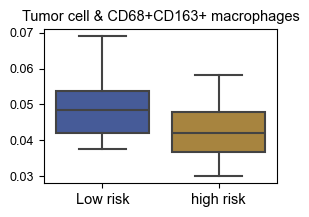

In [81]:
#['#3854a6', '#b8892e', '#872788', '#1b9b52', '#f3756d', '#faf49b', '#1dbec2', '#fdc087', '#bdaed4', '#87a9d9']

plt.figure(figsize=(3, 2))
sns.boxplot(df, x='groups', y='CD68+CD163+ macrophages', palette=['#3854a6', '#b8892e'])

a = plt.gca()
a.set_xticklabels(['Low risk', 'high risk'], fontdict={'family': 'Arial', 'size': 10.5})
a.set_yticklabels(a.get_yticklabels(), fontdict={'family': 'Arial', 'size': 9})

plt.title("Tumor cell & CD68+CD163+ macrophages", fontdict={'family': 'Arial', 'size': 10.5})
plt.xlabel("")
plt.ylabel("")

plt.savefig("fig5c.pdf", bbox_inches="tight"))

Text(45.7222222222222, 0.5, '')

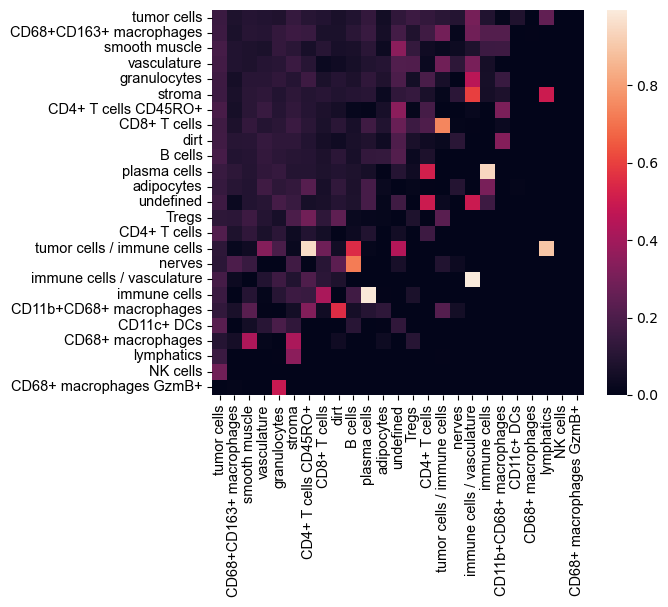

In [81]:
plt.figure(figsize=(6, 5))
sns.heatmap(cell_attns_2d)

a = plt.gca()
a.set_xticklabels(a.get_xticklabels(), fontdict={'family': 'Arial', 'size': 10.5})
a.set_yticklabels(a.get_yticklabels(), fontdict={'family': 'Arial', 'size': 10.5})

plt.xlabel("")
plt.ylabel("")

In [6]:
df2 = pd.melt(pd.DataFrame(Q.numpy().T @ K.numpy(), 
                           index=short_features, columns=short_features), 
              ignore_index=False).reset_index().sort_values(by='value', ascending=False)
df2.iloc[:5]

NameError: name 'Q' is not defined

In [92]:
all_adata.obs['patients'].value_counts()

patients
18    11771
17    10530
4     10344
9     10092
30     9479
16     9287
15     9225
5      9211
21     9184
14     8955
8      8534
13     8425
23     8132
12     7942
3      7866
31     7682
26     7535
7      6735
10     6541
19     6415
25     6399
24     6342
20     6317
28     6295
32     6027
2      6016
6      5935
22     5935
11     5918
1      5616
33     5592
29     5229
35     5214
27     4126
34     3539
Name: count, dtype: int64